In [2]:
from google.colab import drive
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
drive.mount('/content/drive')

# List files in a directory
!ls '/content/drive/My Drive/AN2DL'

# Load the NPZ file
data = np.load('/content/drive/My Drive/AN2DL/training_set_cleaned_balancedwithrotation.npz')

Mounted at /content/drive
training_set_cleaned_balancedwithrotation.npz  training_set.npz


In [3]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
from tqdm import tqdm
# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


2.17.1


In [4]:
# Load dataset
images = data['images']
dataLabels = data['labels']


In [5]:
images.shape

(20000, 96, 96, 3)

In [7]:
from sklearn.model_selection import train_test_split

X = images
y = dataLabels
# Step 1: First, split into train and remaining (test + validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)

# Step 2: Then, split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now, you have:
# X_train, y_train => Training set
# X_val, y_val     => Validation set
# X_test, y_test   => Test set



In [8]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False  # Freeze base model initially

# Add custom classifier head
inputs = tf.keras.Input(shape=(96, 96, 3))
x = base_model(inputs, training=False)  # Ensure base model behaves properly during training
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)  # Fully connected layer with L2 regularization
x = Dropout(0.6)(x)  # Dropout to prevent overfitting
outputs = Dense(8, activation='softmax')(x)  # Output layer (8 classes)

# Define the model
model = Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
history = model.fit(
    x=X_train,  # Input data (features)
    y=y_train,  # Labels (targets)
    batch_size=32,  # Number of samples per gradient update
    epochs=10,  # Number of times to iterate over the training data
    verbose=1,  # Display progress bar (0 = silent, 1 = progress bar, 2 = one line per epoch)
    validation_data=(X_val,y_val),
    shuffle=True,  # Whether to shuffle the training data before each epoch
)



Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 121s 203ms/step - accuracy: 0.3804 - loss: 1.7927 - val_accuracy: 0.7160 - val_loss: 0.8879
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 142s 204ms/step - accuracy: 0.6484 - loss: 0.9862 - val_accuracy: 0.7370 - val_loss: 0.7541
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 140s 200ms/step - accuracy: 0.6993 - loss: 0.8500 - val_accuracy: 0.7570 - val_loss: 0.6892
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 141s 198ms/step - accuracy: 0.7214 - loss: 0.7666 - val_accuracy: 0.7690 - val_loss: 0.6471
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 166s 240ms/step - accuracy: 0.7407 - loss: 0.7291 - val_accuracy: 0.7710 - val_loss: 0.6237
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 140s 238ms/step - accuracy: 0.7555 - loss: 0.6977 - val_accuracy: 0.7830 - val_loss: 0.6046
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 139s 232ms/step - accuracy: 0.7687 - loss: 0.6613 - val_accuracy: 0.7840 - val_loss: 0.5878
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 146s 239ms/step - accuracy: 0.7752 -

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.8074 - loss: 0.5342


In [11]:
# Now, fine-tuning: Unfreeze some or all of the layers in the base model
base_model.trainable = True  # Unfreeze the entire base model (or the last few layers)
# Optionally, you can unfreeze only the last few layers of the base model
# For example, unfreeze the last 40 layers:
for layer in base_model.layers[:-40]:
     layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=AdamW(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary after unfreezing
model.summary()

# Fine-tune the model (train the entire model now)
history_finetune = model.fit(
    x=X_train,  # Input data (features)
    y=y_train,  # Labels (targets)
    batch_size=32,  # Number of samples per gradient update
    epochs=10,  # Number of times to iterate over the training data
    verbose=1,  # Display progress bar (0 = silent, 1 = progress bar, 2 = one line per epoch)
    validation_data=(X_val,y_val),
    shuffle=True,  # Whether to shuffle the training data before each epoch
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 2,011,528 (7.67 MB)

 Non-trainable params: 576,448 (2.20 MB)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 242s 405ms/step - accuracy: 0.4478 - loss: 2.0173 - val_accuracy: 0.6470 - val_loss: 1.1648
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 252s 387ms/step - accuracy: 0.7147 - loss: 0.8235 - val_accuracy: 0.7500 - val_loss: 0.7637
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 269s 400ms/step - accuracy: 0.7847 - loss: 0.6319 - val_accuracy: 0.8080 - val_loss: 0.5831
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 264s 405ms/step - accuracy: 0.8183 - loss: 0.5216 - val_accuracy: 0.8270 - val_loss: 0.5075
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 279s 434ms/step - accuracy: 0.8493 - loss: 0.4419 - val_accuracy: 0.8450 - val_loss: 0.4598
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 229s 407ms/step - accuracy: 0.8765 - loss: 0.3706 - val_accuracy: 0.8540 - val_loss: 0.4367
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 231s 410ms/step - accuracy: 0.8986 - loss: 0.3079 - val_accuracy: 0.8630 - val_loss: 0.4243
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 254s 396ms/step - accuracy: 0.9166 -

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - accuracy: 0.8558 - loss: 0.4615


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 580ms/step
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       111
           1       0.89      0.92      0.90       134
           2       0.86      0.88      0.87       118
           3       0.63      0.53      0.58       107
           4       0.89      0.87      0.88       124
           5       0.78      0.85      0.81       132
           6       0.86      0.91      0.88       121
           7       0.98      0.99      0.99       153

    accuracy                           0.86      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.86      0.85      1000



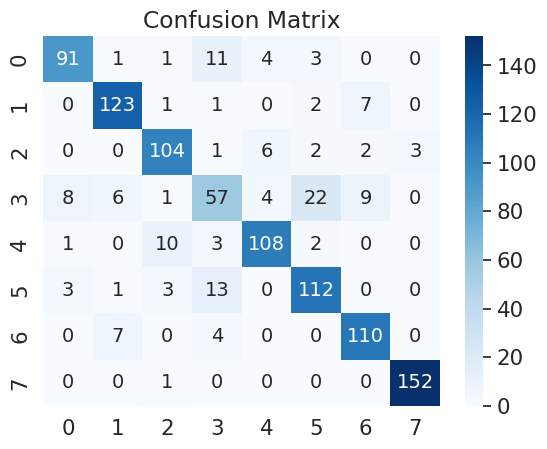

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
test_predictions = model.predict(X_test)
y_pred = np.argmax(test_predictions, axis=1)  # Get the predicted class

# Classification Report
print(classification_report(y_test, y_pred))  # test_labels: the true test labels

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [16]:
# Save the final model
model.save("weights.keras")

from google.colab import files

# Replace 'your_file.txt' with the actual file path
files.download('weights.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>